In [ ]:
### Libraries

In [4]:
import os
from io import BytesIO
import requests
from datetime import datetime,timedelta
import warnings
import xarray as xr
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import pandas as pd
import matplotlib.patheffects as path_effects
from matplotlib.colors import ListedColormap
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
import image_functions as imagef
import plotting_functions as plotf
import helper_dicts as hdict
import helper_functions as helper
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
layerlinks = {
            'Monitor Tools': {
                'OISST SST 7-Day Anomaly': 'https://www.cpc.ncep.noaa.gov/products/international/oisst/oisst_7day_pac_anom.gif',
                'OISST SST 7-Day Anomaly Difference': 'https://www.cpc.ncep.noaa.gov/products/international/oisst/oisst_7day_pac_diff.gif',
                # 'CMORPH Time Series Points': 'https://www.cpc.ncep.noaa.gov/products/international/zz_CP_Islands/zz_CMORPH_BLD_2nd/CMORPH_BLD_Islands_180day.shtml',
                'CMORPH 90 Day Precip Anomaly': 'https://www.cpc.ncep.noaa.gov/products/international/drought/precip/img/Anom_90day_PacificIslands.png',
                'CMORPH 90 Day Precip Percent': 'https://www.cpc.ncep.noaa.gov/products/international/drought/precip/img/Perc_90day_PacificIslands.png',
                'CMORPH 3-month SPI': 'https://www.cpc.ncep.noaa.gov/products/international/dm/daily/Pacific_CMORPH_SPI_3mo.png',
                'CMORPH 3-month SPEI': 'https://www.cpc.ncep.noaa.gov/products/international/dm/daily/Pacific_CMORPH_SPEI_3mo.png',
                'CMORPH 30 Day Precip Anomaly': 'https://www.cpc.ncep.noaa.gov/products/international/drought/precip/img/Anom_30day_PacificIslands.png',
                'CMORPH 30 Day Precip Percent': 'https://www.cpc.ncep.noaa.gov/products/international/drought/precip/img/Perc_30day_PacificIslands.png',
                'CMORPH 1-month SPI': 'https://www.cpc.ncep.noaa.gov/products/international/dm/daily/Pacific_CMORPH_SPI_1mo.png',
                'CMORPH 1-month SPEI': 'https://www.cpc.ncep.noaa.gov/products/international/dm/daily/Pacific_CMORPH_SPEI_1mo.png',
                'Leaky Bucket Model 1-month Surface Runoff Index': 'https://www.cpc.ncep.noaa.gov/products/people/lxu/leaky/smp/SRI1_PacificIslands.png',
                'CMORPH 7 Day Precip Total': 'https://www.cpc.ncep.noaa.gov/products/international/drought/precip/img/Total_7day_PacificIslands.png',
                'CMORPH 7 Day Precip Anomaly': 'https://www.cpc.ncep.noaa.gov/products/international/drought/precip/img/Anom_7day_PacificIslands.png',
                'CMORPH 7 Day SPI': 'https://www.cpc.ncep.noaa.gov/products/international/dm/daily/Pacific_CMORPH_SPI_1wk.png',
                'CDAS 7 Day Tmax':  'https://ftp.cpc.ncep.noaa.gov/rshukla/CDAS/CDAS_7dy_Tmax_Ave_CPI.png',
                'CDAS 7 Day Tmax Anomaly': 'https://ftp.cpc.ncep.noaa.gov/rshukla/CDAS/CDAS_7dy_Tmax_anom_CPI.png'
                # 'VHI 1km': 'https://www.ncei.noaa.gov/pub/data/nidis/tile/noaa-vhi-1km/{z}/{x}/{y}.png',
                # 'NASA ESI': 'https://www.ncei.noaa.gov/pub/data/nidis/tile/nasa-esi-5km-4wk/{z}/{x}/{y}.png'
            },
            'Forecast Tools': {
                'GEFS Week 1 Precip Total Forecast':  'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week1_figures/gefs_week1_precipt.png',
                'GEFS Week 1 Precip Anomaly Forecast': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week1_figures/gefs_week1_precip.png',
                'GEFS Week 1 Precip Exceedance Prob (50 mm)': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week1_figures/gefs_week1_prob_50.png',
                'GEFS Week 1 Precip Exceedance Prob (100 mm)': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week1_figures/gefs_week1_prob_100.png',
                'GEFS Week 1 Raw Precip Tercile Prob': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_calib/fig_dir/gefs_week_1_raw.png',
                'GEFS Week 1 Consolidated Precip Tercile Prob': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_calib/fig_dir/gefs_week_1_cons.png',
                'GEFS Week 1 Temp Total Forecast': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week1_figures/gefs_week1_t2mt.png',
                'GEFS Week 1 Temp Anomaly Forecast': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week1_figures/gefs_week1_t2m.png',
                'Leaky Bucket Model Evaporative Stress Index Week 1 Forecast': 'https://www.cpc.ncep.noaa.gov/products/people/lxu/leaky/smp/ESI_Week1_PacificIslands.png',
                'Leaky Bucket Model Soil Moisture Percentile Week 1 Forecast':'https://www.cpc.ncep.noaa.gov/products/people/lxu/leaky/smp/SMP_Week1_PacificIslands.png',
                'Leaky Bucket Model SPI Week 1 Forecast': 'https://www.cpc.ncep.noaa.gov/products/people/lxu/leaky/smp/SPI3_Week1_PacificIslands.png',
                'GEFS Week 2 Precip Total':'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week2_figures/gefs_week2_precipt.png',
                'GEFS Week 2 Precip Anomaly': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week2_figures/gefs_week2_precip.png',
                'GEFS Week 2 Temp Total Forecast': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week2_figures/gefs_week2_t2mt.png',
                'GEFS Week 2 Temp Anomaly Forecast': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week2_figures/gefs_week2_t2m.png',
                'GEFS Week 2 Precip Exceedance Prob (50 mm)': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week2_figures/gefs_week2_prob_50.png',
                'GEFS Week 2 Precip Exceedance Prob (100 mm)': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_raw/gefs_week2_figures/gefs_week2_prob_100.png',
                'GEFS Week 2 Raw Precip Tercile Prob': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_calib/fig_dir/gefs_week_2_raw.png',
                'GEFS Week 2 Consolidated Precip Tercile Prob': 'https://ftp.cpc.ncep.noaa.gov/International/PREPARE_Pacific/subseasonal/gefs_calib/fig_dir/gefs_week_2_cons.png',
                'NMME 1 Month Precip Anomaly Forecast': 'https://www.cpc.ncep.noaa.gov/products/international/drought/nmme/Multi_Model_Ensemble_Panom_L1_PacificIslands.png',
                'NMME 1 Month SPI Forecast': 'https://www.cpc.ncep.noaa.gov/products/international/drought/nmme/Multi_Model_Ensemble_SPI3_L1_PacificIslands.png'
            }
        }

monitor_save = ['oisst', 'oisst_diff', 'cmorph90anom', 'cmorph90percent', 'cmorph3mospi', 'cmorph3mospei', 'cmorph30panom', 'cmorph30ppercent',
                'cmorph1mospi', 'cmorph1mospei', 'lbm1mosri', 'cmorph7ptotal', 'cmorph7panom', 'cmorph7spi', 'cdas7tmax', 'cdas7tanom']
fcst_save = ['gefswk1ptotal', 'gefswk1panom', 'gefswk1poe50', 'gefswk1poe100', 'gefswk1rawter', 'gefswk1conster', 
             'gefswk1ttotal', 'gefswk1tanom', 'lbmwk1esi', 'lbmwk1smp', 'lbmwk1spi', 'gefswk2ptotal', 'gefswk2panom', 'gefswk2ttotal', 'gefswk2tanom',
             'gefswk2poe50', 'gefswk2poe100', 'gefswk2rawter', 'gefswk2conster', 'nmme1mopanom', 'nmme1mospi']

OISST SST 7-Day Anomaly


NameError: name 'os' is not defined

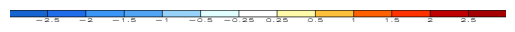

In [6]:
figure_dir = '/cpc/int_desk/pac_isl/stations/images'
legend_crop_monitors = [(150, 1420, 2350,1475), (150, 1420, 2350,1475), #oisst
                        (90, 600, 920, 630),  (90, 600, 920, 630), #cmorph 90
                        (150, 650, 890, 695), (150, 650, 885, 683), #cmorph 3mo spi, spei
                        (90, 600, 920, 630), (90, 600, 920, 630), #cmorph 30
                        (150, 650, 890, 695), (150, 650, 885, 683), #cmorph 1mo spi, spei
                        (55, 580, 885, 630),  #lbm sri,
                        (90, 600, 920, 630),  (90, 600, 920, 630), #cmorph 90
                        (150, 650, 890, 695), #cmorph 7day spi
                       (20, 435, 755, 470),  (20, 435, 755, 470)] #cdas 7
legend_crop_fcsts = [(35, 360, 590, 400), (35, 360, 590, 400), (35, 360, 590, 400), (35, 360, 590, 400), #wk1 panom, total, poes
                     (110, 820, 1760, 980),  (110, 820, 1760, 990), #terc forecasts
             (35, 360, 590, 400), (35, 360, 590, 400), #gefswk1 tanom, total
                    (55, 580, 885, 630), (55, 580, 885, 630), (55, 580, 885, 630), #lbm
                     (35, 360, 590, 400), (35, 360, 590, 400), (35, 360, 590, 400), (35, 360, 590, 400), #wk2 p and t
            (35, 360, 590, 400), (35, 360, 590, 400), #wk 2 poe
                     (120, 820, 1760, 980),  (120, 820, 1760, 990), 
                    (90, 600, 920, 630), (90, 600, 920, 630)]#nmme fcsts

crop_monitors = [(148, 250, 2247, 1300), (148, 250, 2247, 1300),#(148, 151, 2247,1377), (148, 151, 2247,1377), #oisst
                        (42, 76, 971, 535),  (42, 76, 971, 535), #cmorph 90
                        (56, 76, 1014, 568), (56, 76, 1004, 554), #cmorph 3mo spi, spei
                        (42, 76, 971, 535), (42, 76, 971, 535), #cmorph 30
                        (56, 76, 1014, 568), (56, 76, 1004, 554), #cmorph 1mo spi, spei
                        (43, 89, 878, 502),  #lbm sri,
                        (42, 76, 971, 535),  (42, 76, 971, 535), #cmorph 7
                        (56, 76, 1014, 568), #cmorph 7day spi
                       (26, 39, 751, 409),  (26, 43, 751, 409)] #cdas 7

crop_fcsts = [(46, 63, 588, 339),  (46, 63, 588, 339), (46, 63, 588, 338), (46, 63, 588, 338), #wk1 panom, total, poes
                     (121, 62, 1745, 757),  (131, 75, 1755, 767), #terc forecasts
             (46, 63, 588, 338), (46, 63, 588, 338), #gefswk1 tanom, total
                    (43, 87, 878, 500), (43, 87, 878, 500), (43, 87, 878, 500), #lbm
                     (46, 63, 588, 339), (46, 63, 588, 339), (46, 63, 588, 338), (46, 63, 588, 338), #wk2 p and t
            (46, 63, 588, 338), (46, 63, 588, 338), #wk 2 poe
                    (121, 62, 1745, 757),  (131, 75, 1755, 767), 
                   (41, 73, 970, 532), (41, 73, 970, 532)]#nmme fcsts

def crop_image_for_leaflet(layerlink_cat, crops, save_names, fig_type, figure_dir):
    for k, key in enumerate(layerlink_cat):
        print(key)
        path = Image.open(BytesIO(requests.get(layerlink_cat[key]).content))
        cropped_image = path.crop(crops[k])
        if cropped_image.mode in ('RGBA', 'LA') or (cropped_image.mode == 'P' and 'transparency' in cropped_image.info):
           cropped_image = cropped_image.convert('RGBA')  # Convert for transparency, or 'RGB' if transparency isn't needed
        plotf.save_image(cropped_image, save_names[k] + '_' + fig_type, figure_dir)
        
crop_image_for_leaflet(layerlinks['Monitor Tools'], legend_crop_monitors, monitor_save, 'legend', figure_dir)
crop_image_for_leaflet(layerlinks['Forecast Tools'], legend_crop_fcsts, fcst_save, 'legend', figure_dir)
crop_image_for_leaflet(layerlinks['Monitor Tools'], crop_monitors, monitor_save, 'data', figure_dir)
crop_image_for_leaflet(layerlinks['Forecast Tools'], crop_fcsts, fcst_save, 'data', figure_dir)

In [ ]:
# spei_path = Image.open(BytesIO(requests.get(layerlinks['Monitor Tools']['CMORPH 1-month SPEI']).content))
# spei_colorbar = imagef.convert_image_to_array(spei_path, (150, 650, 900, 660))
# spei_colors = imagef.calc_unique_colors(spei_colorbar)
# spei_colors = {imagef.closest_color_category(color, hdict.color_categories): tuple(color.tolist()) for color in spei_colors}
# pac_cropw = (45,65, 676, 555) #65
# pac_crope = (676,65, 1004, 555)
# pac_coordsw = (132, 180, 9, -22) #is 10 
# pac_coordse = (180, 205, 9, -22)
# spei_pacw = imagef.convert_image_to_array(spei_path, pac_cropw)
# spei_pace = imagef.convert_image_to_array(spei_path, pac_crope)
# spei_pacw = imagef.convert_image_to_coordinates(spei_pacw, pac_coordsw[0], pac_coordsw[1], pac_coordsw[2], pac_coordsw[3])
# spei_pace = imagef.convert_image_to_coordinates(spei_pace, pac_coordse[0], pac_coordse[1], pac_coordse[2], pac_coordse[3])
# spei_pac = pd.concat([spei_pacw, spei_pace], ignore_index = True)
# df_spei_pac = imagef.convert_df_to_reduced_gdf(spei_pac, 1, 1)
# df_spei_pac = imagef.convert_color(df_spei_pac)
# df_spei_pac.x = (df_spei_pac.x + 360)%360

In [ ]:
# df_spei_pac.plot(color = df_spei_pac['color'])